In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import planarity
from networkx.algorithms import community
# import make_mst
# import make_pmfg
import collections

In [2]:
raw_data = pd.read_csv('cleaned_data.csv',index_col=0)
name_need = raw_data[raw_data['month']=='2020-12'][['简称','subsector']].drop_duplicates()
name_need.set_index(["简称"], inplace=True)
name_need

,subsector
简称,
中信证券,资本市场服务
华安证券,资本市场服务
中国银河,资本市场服务
国泰君安,资本市场服务
招商证券,资本市场服务
...,...
新力金融,其他金融业
中航资本,其他金融业
仁东控股,其他金融业


In [3]:
months = raw_data['month'].drop_duplicates()
months[0]

'2010-01'

In [4]:
# dist
def get_graph_dist(month):
    raw_data = pd.read_csv('cleaned_data.csv',index_col=0)
    one_month = raw_data[raw_data['month']==month]
    pivot_m = pd.pivot_table(data=one_month,values='return',columns='简称',index='日期')
    corr=pivot_m.corr()
    distance_m = pd.DataFrame(np.tril(np.sqrt(2*(1-corr))))
    distance_m.columns=corr.columns
    distance_m.index=corr.columns
    zipped = []
    for i in range(len(distance_m.columns)):
        zipped.append(list(zip([distance_m.columns[i]]*distance_m.shape[0],distance_m.index,distance_m[distance_m.columns[i]])))
    List_flat = []
    for i in zipped:
        for j in i:
            if not np.isnan(j[2]):
                List_flat.append(j)
    s_List_flat = list(set(List_flat))
    # print(len(s_List_flat))
    List = []
    for i in range(len(s_List_flat)):
        # print(s_List_flat[i])
        if float(s_List_flat[i][2])!=0:
            List.append(s_List_flat[i])
    G = nx.Graph()
    node_list = list([x for x,y,z in s_List_flat])
    for i in range(len(node_list)):
        if one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '资本市场服务':
            G.add_node(node_list[i],color ='yellow')
        elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '保险业':
            G.add_node(node_list[i],color ='blue')
        elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '货币金融':
            G.add_node(node_list[i],color ='red')
        elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '其他金融业':
            G.add_node(node_list[i],color ='green')
    G.add_weighted_edges_from(List)
    return G

def sort_graph_edges_dist(G):
    sorted_edges = []
    tmp = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse = False)
    for source, dest, data in tmp: # in descending order!
        sorted_edges.append({'source': source,
                            'dest': dest,
                            'weight': data['weight']})
    return sorted_edges

def compute_PMFG(G):
    PMFG = nx.Graph() 
    ne_total = G.number_of_edges()
    nb_nodes = len(G.nodes)
    ne_pmfg = 3*(nb_nodes-2)
    sorted_edges = sort_graph_edges_dist(G)
    t0 = time.time()
    for i, edge in enumerate(sorted_edges):
        PMFG.add_edge(edge['source'], edge['dest'], weight = edge['weight'])
        if not planarity.is_planar(PMFG):
            PMFG.remove_edge(edge['source'], edge['dest'])
        ne = PMFG.number_of_edges()
        print("Generating PMFG... added edges in PMFG %d/%d (%.2f%%) lookup edges in G %d/%d (%.2f%%) Elapsed TIme %.2f [sec]"            %(ne, ne_pmfg, (ne/ne_pmfg)*100, i, ne_total, (i+1/ne_total)*100, time.time()-t0), end="\r")
        if ne == ne_pmfg:
            break
    return PMFG

def entropy(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print(degree_sequence)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    pros = np.matrix(np.array(cnt))/sum(cnt)

    etp = -pros*np.log(pros).T
    # print(float(etp[0]))
    return float(etp[0])

In [7]:
def save_graph(month):
    raw_data = pd.read_csv('cleaned_data.csv',index_col=0)
    one_month = raw_data[raw_data['month']==month]
    G = get_graph_dist(month)
    pfmg = compute_PMFG(G)
    # node_list = list(pfmg.nodes())
    # for i in range(len(node_list)):
    #     print(node_list[i])
    #     if one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '资本市场服务':
    #         pfmg1.nodes[node_list[i]]['color'] ='yellow'
    #     elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '保险业':
    #         pfmg1.nodes[node_list[i]]['color'] ='blue'
    #     elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '货币金融':
    #         pfmg1.nodes[node_list[i]]['color'] ='red'
    #     elif one_month[one_month['简称']==node_list[i]].iloc[0]['subsector'] == '其他金融业':
    #         pfmg1.nodes[node_list[i]]['color'] ='green'
    # color = []
    # color_map = dict(pfmg.nodes)
    # # print(color_map)
    # for node in color_map.items():
    #     color.append(node[1]['color'])
    
    # plt.figure(figsize=(10,10))
    # plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    # nx.draw_spring(pfmg1,with_labels=True,node_color = color)
    nx.write_gpickle(pfmg,f'graph_info/{month}.gpickle')

In [8]:
for i in months:
    save_graph(i)

# entropy

In [8]:
entropy_l_pmfg = []
t0 = time.time()
for i in months:
    # print(i)
    G = get_graph_dist(i)
    pmfg = compute_PMFG(G)
    # nx.write_gpickle(pmfg, f"42_currencies_graph/{i}.gpickle")
    etp = entropy(pmfg)
    entropy_l_pmfg.append(etp)
print('time used: ', time.time()-t0)


KeyboardInterrupt: 

In [ ]:
plt.plot(entropy_l_pmfg)

# degree_centrality 

In [19]:
def get_ts(y_month):
    entropy_l_pmfg = []
    t0 = time.time()
    for i in dates[1:-2]:
        # print(i)
        G = get_graph_dist(str(i))
        pmfg = compute_PMFG(G)
        nx.write_gpickle(f'graph_info/{}')        
        etp = entropy(pmfg)
        entropy_l_pmfg.append(etp)
    print('time used: ', time.time()-t0)


    
    G = get_graph_dist(y_month)
    pfmg = compute_PMFG(G)
    raw_data = pd.read_csv('cleaned_data.csv',index_col=0)
    name_need = raw_data[raw_data['month']=='2020-12'][['简称','subsector']].drop_duplicates()
    name_need.set_index(["简称"], inplace=True)
    # name_need
    degree_centrality=nx.degree_centrality(pfmg)
    degree_centrality_list= sorted(degree_centrality.items(),key=lambda x:x[1],reverse=True)
    keys = [k[0] for k in degree_centrality_list]
    values = [k[1] for k in degree_centrality_list] 
    df_degree_centrality = pd.DataFrame(degree_centrality,index=[y_month]).T
    df_degree_centrality = df_degree_centrality.join(name_need, lsuffix='_')
    data = df_degree_centrality.groupby(by='subsector').mean()
    # print(data)
    return data

In [20]:
frames = []
for m in months:
    frames.append(get_ts(m))

In [23]:
degree_frame = pd.concat(frames,axis=1)
degree_frame

,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,...,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01
subsector,,,,,,,,,,,,,,,,,,,,,
保险业,0.092857,0.073684,0.098305,0.077966,0.067797,0.080000,0.056034,0.056034,0.103333,0.085246,...,0.037851,0.029304,0.050420,0.055222,0.036905,0.036905,0.038961,0.032787,0.049180,0.048009
其他金融业,0.094866,0.082237,0.065678,0.070975,0.086864,0.080392,0.074353,0.072198,0.079167,0.095287,...,0.039316,0.036752,0.033213,0.044418,0.038095,0.042063,0.042109,0.036690,0.039032,0.043326
货币金融,0.103571,0.126316,0.114124,0.118644,0.109605,0.098889,0.121839,0.131466,0.112745,0.099325,...,0.053531,0.046334,0.055064,0.048430,0.053509,0.047807,0.051282,0.050231,0.043085,0.046868
资本市场服务,0.112245,0.105263,0.110169,0.108051,0.105226,0.110417,0.110632,0.104948,0.095652,0.094262,...,0.054024,0.061280,0.051976,0.051665,0.051970,0.054394,0.050789,0.053425,0.055474,0.051376


In [41]:
degree_frame = degree_frame/np.sum(degree_frame)
degree_frame.to_csv('degree_frame.csv')

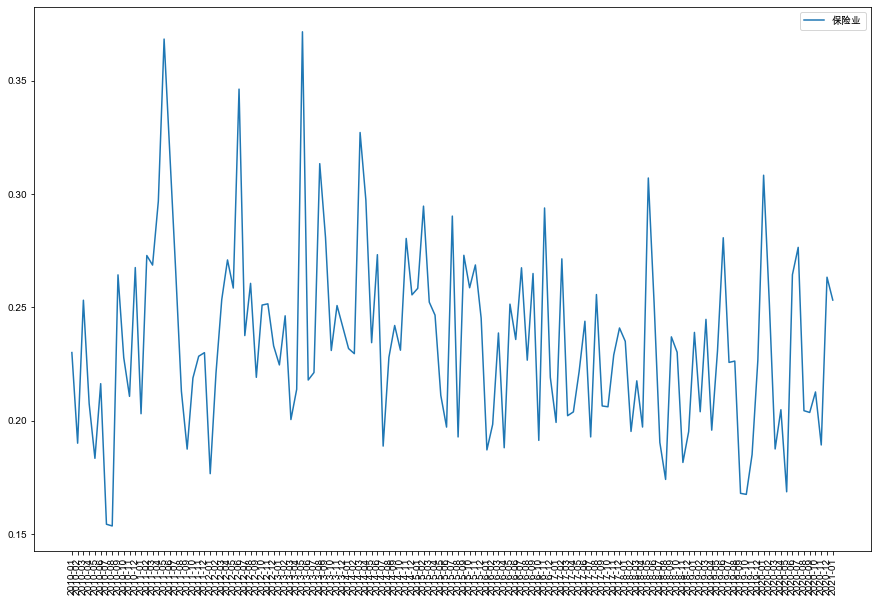

In [36]:
plt.figure(figsize=(15,10))
plt.plot(degree_frame.iloc[0],label='保险业')
# plt.plot(degree_frame.iloc[1],label='其他金融业')
# plt.plot(degree_frame.iloc[2],label='货币金融')
# plt.plot(degree_frame.iloc[3],label='资本市场服务')
plt.xticks(rotation=90)
plt.legend()
plt.show()

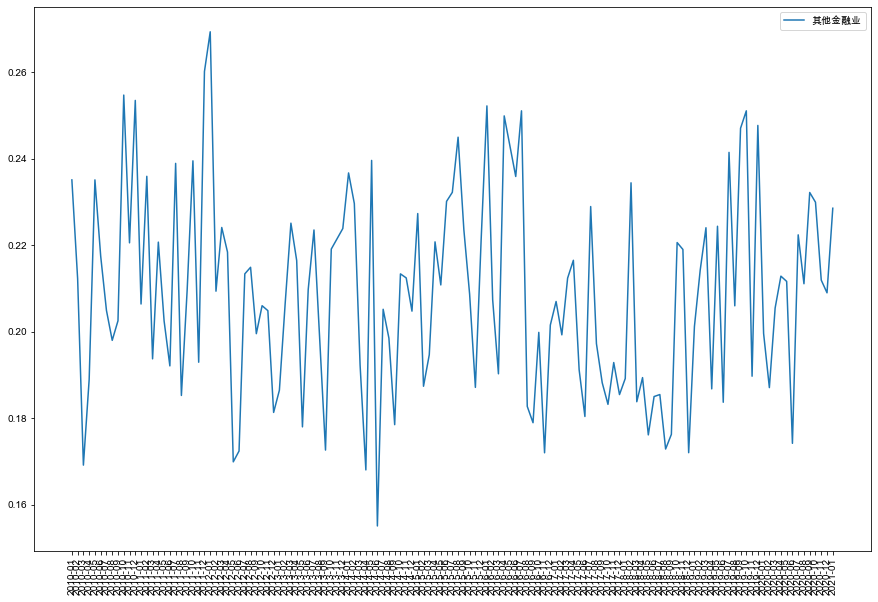

In [37]:
plt.figure(figsize=(15,10))
# plt.plot(degree_frame.iloc[0],label='保险业')
plt.plot(degree_frame.iloc[1],label='其他金融业')
# plt.plot(degree_frame.iloc[2],label='货币金融')
# plt.plot(degree_frame.iloc[3],label='资本市场服务')
plt.xticks(rotation=90)
plt.legend()
plt.show()

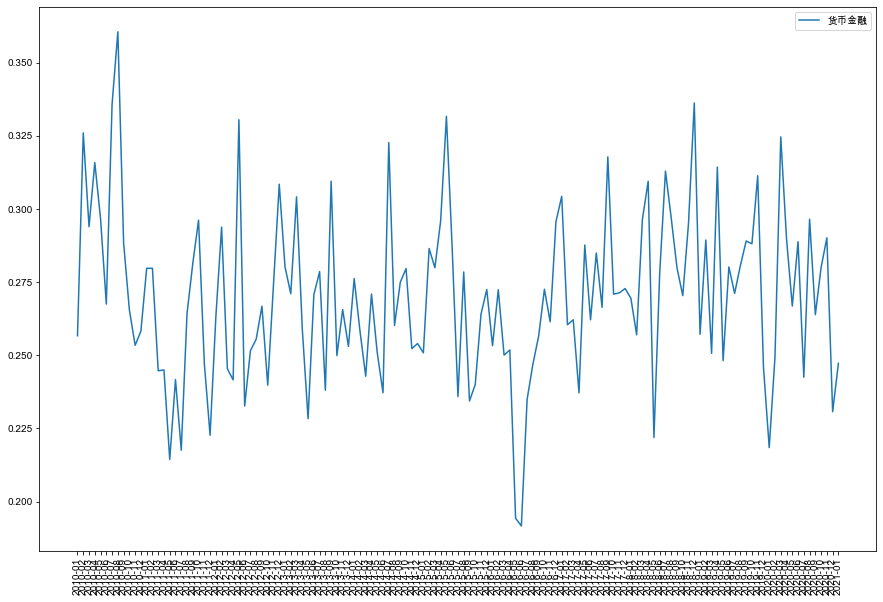

In [38]:
plt.figure(figsize=(15,10))
# plt.plot(degree_frame.iloc[0],label='保险业')
# plt.plot(degree_frame.iloc[1],label='其他金融业')
plt.plot(degree_frame.iloc[2],label='货币金融')
# plt.plot(degree_frame.iloc[3],label='资本市场服务')
plt.xticks(rotation=90)
plt.legend()
plt.show()

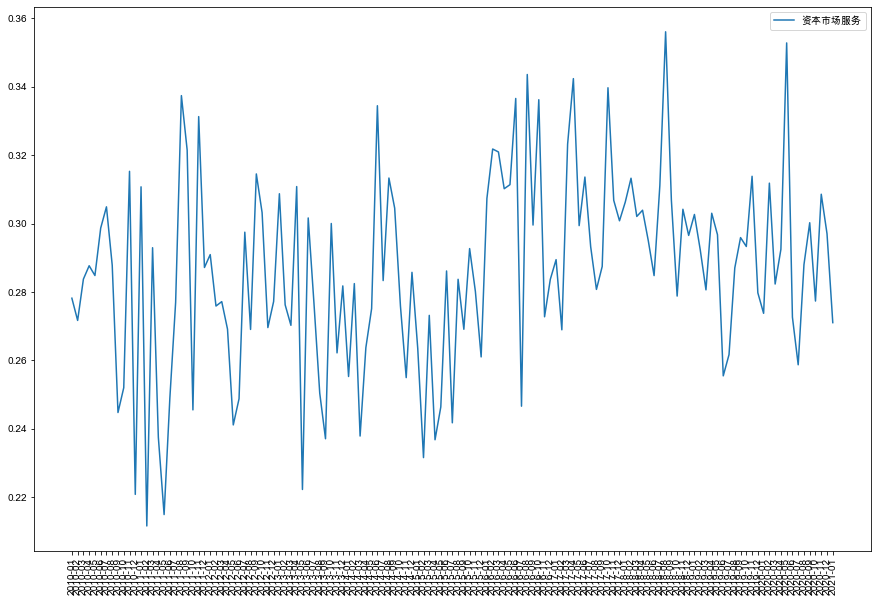

In [39]:
plt.figure(figsize=(15,10))
# plt.plot(degree_frame.iloc[0],label='保险业')
# plt.plot(degree_frame.iloc[1],label='其他金融业')
# plt.plot(degree_frame.iloc[2],label='货币金融')
plt.plot(degree_frame.iloc[3],label='资本市场服务')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [88]:

degree_centrality=nx.degree_centrality(pfmg1) 

degree_centrality_list= sorted(degree_centrality.items(),key=lambda x:x[1],reverse=True)

keys = [k[0] for k in degree_centrality_list]
values = [k[1] for k in degree_centrality_list]
# degree_centrality_list

In [90]:
# plt.figure(figsize=(25,8))
# plt.xticks(rotation=90)
# plt.plot(keys,values)


In [95]:
df_degree_centrality = pd.DataFrame(degree_centrality,index=['degree_centrality']).T
# print(df_degree_centrality)

df_degree_centrality = df_degree_centrality.join(name_need, lsuffix='_')
# print(df_degree_centrality.shape)
df_degree_centrality

       degree_centrality
东吴证券            0.155738
申万宏源            0.155738
西安银行            0.049180
青农商行            0.073770
天风证券            0.065574
...                  ...
仁东控股            0.024590
国网英大            0.024590
*ST安信           0.024590
西部资源            0.024590
*ST熊猫           0.024590

[123 rows x 1 columns]


,degree_centrality,subsector
东吴证券,0.155738,资本市场服务
申万宏源,0.155738,资本市场服务
西安银行,0.049180,货币金融
青农商行,0.073770,货币金融
天风证券,0.065574,资本市场服务
...,...,...
仁东控股,0.024590,其他金融业
国网英大,0.024590,其他金融业
*ST安信,0.024590,其他金融业
西部资源,0.024590,货币金融


In [96]:
df_degree_centrality.groupby(by='subsector').mean()

,degree_centrality
subsector,
保险业,0.032787
其他金融业,0.036690
货币金融,0.050231
资本市场服务,0.053425


# betweenness_centrality

In [11]:
between_centrality=nx.betweenness_centrality(pfmg1) 

between_centrality_list= sorted(between_centrality.items(),key=lambda x:x[1],reverse=True)

keys = [k[0] for k in between_centrality_list]
values = [k[1] for k in between_centrality_list]


NameError: name 'pfmg1' is not defined

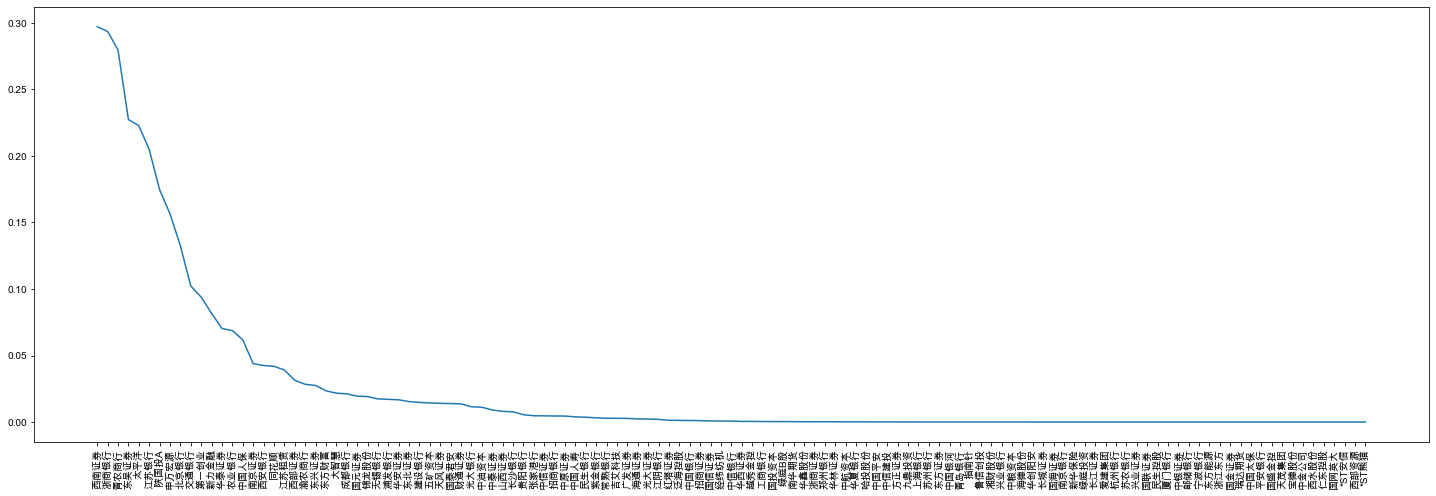

In [26]:
plt.figure(figsize=(25,8))
plt.xticks(rotation=90)
plt.plot(keys,values)

# degree_centrality

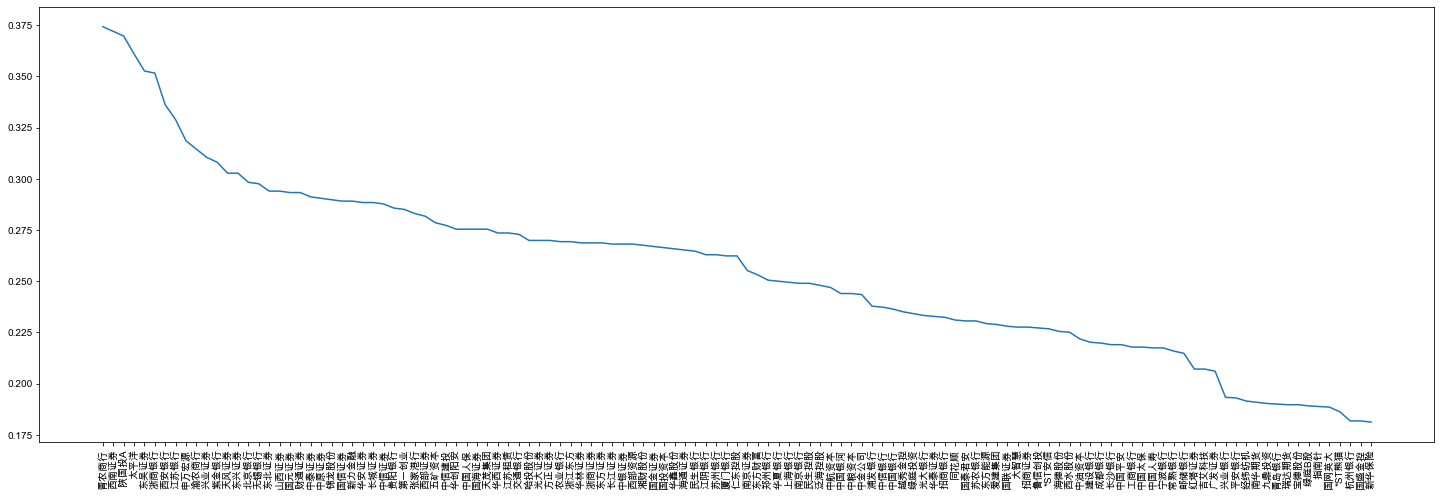

In [27]:
closeness_centrality=nx.degree_centrality(pfmg1) 

closeness_centrality_list= sorted(closeness_centrality.items(),key=lambda x:x[1],reverse=True)

keys = [k[0] for k in closeness_centrality_list]
values = [k[1] for k in closeness_centrality_list]
plt.figure(figsize=(25,8))
plt.xticks(rotation=90)
plt.plot(keys,values)
